In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import defaultdict
from sklearn.impute import SimpleImputer

In [2]:
calender = pd.read_csv(r"C:\Users\ethanwilliams\Desktop\airbnb_ml\Boston\calendar.csv")
listings = pd.read_csv(r"C:\Users\ethanwilliams\Desktop\airbnb_ml\Boston\listings.csv")
reviews = pd.read_csv(r"C:\Users\ethanwilliams\Desktop\airbnb_ml\Boston\reviews.csv")

In [3]:
listings.shape

(3585, 95)

In [4]:
reviews.shape

(68275, 6)

In [5]:
calender.shape

(1308890, 4)

In [6]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [7]:
calender.columns

Index(['listing_id', 'date', 'available', 'price'], dtype='object')

In [8]:
calender.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


In [9]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [10]:
listings['id'][:50]

0     12147973
1      3075044
2         6976
3      1436513
4      7651065
5     12386020
6      5706985
7      2843445
8       753446
9       849408
10    12023024
11     1668313
12     2684840
13    13547301
14     5434353
15      225979
16     3420384
17    13512930
18     7482195
19     7252607
20     2583074
21    13251243
22      225834
23     6400432
24     5498472
25      894539
26      879929
27     9218312
28      321328
29     1810172
30     6513924
31     7093109
32    14690527
33     7086825
34     1861070
35     4283698
36    10116095
37     8548176
38     4922204
39     4085362
40     3755609
41    13768853
42     1936861
43     4461111
44     1724900
45    13937181
46     3968797
47     1494726
48     8473851
49     3575220
Name: id, dtype: int64

In [11]:
listings = listings.dropna(subset=['id',"price"], axis=0)
listings['price'] = listings['price'].map(lambda x: x.lstrip('$'))
listings['price'] = listings['price'].replace(',','', regex=True)
listings['id'] = listings['id'].astype(int)
listings['price'] = listings['price'].astype(float)

# Questions 1: 
## How does price change over time for rentals? and do Holidays effect the price

In [12]:
calender_date = calender[['date','available','listing_id']]
listings_price = listings[['price']]
df_price_query = pd.concat([calender_date, listings_price], axis=1)

In [13]:
print(df_price_query.sort_values(by=['date'], ascending=False))

               date available  listing_id  price
0        2017-09-05         f    12147973  250.0
437528   2017-09-05         f      901914    NaN
441480   2017-09-05         t     1425973    NaN
441146   2017-09-05         f     9094794    NaN
440555   2017-09-05         t    14489201    NaN
...             ...       ...         ...    ...
416099   2016-09-06         f     8753913    NaN
416464   2016-09-06         f     9949819    NaN
416829   2016-09-06         f     2495047    NaN
417194   2016-09-06         f     9853959    NaN
1308889  2016-09-06         f    14504422    NaN

[1308890 rows x 4 columns]


In [14]:
df_price_query = df_price_query.dropna(subset=['listing_id',"price"], axis=0)
df_price_query

,date,available,listing_id,price
0,2017-09-05,f,12147973,250.0
1,2017-09-04,f,12147973,65.0
2,2017-09-03,f,12147973,65.0
3,2017-09-02,f,12147973,75.0
4,2017-09-01,f,12147973,79.0
...,...,...,...,...
3580,2016-11-14,t,849408,69.0
3581,2016-11-13,t,849408,150.0
3582,2016-11-12,t,849408,198.0
3583,2016-11-11,t,849408,65.0


In [73]:
#df_price_query['date'] = pd.to_datetime(df_price_query['date']) 
#df_price_query['price'] = df_price_query['price'].map(lambda x: x.lstrip('$'))
#df_price_query['price'] = df_price_query['price'].replace(',','', regex=True)


In [16]:
df_price_query['listing_id'] = df_price_query['listing_id'].astype(int)
df_price_query['price'] = df_price_query['price'].astype(float)

In [17]:
df_price_query.dtypes

date          datetime64[ns]
available             object
listing_id             int32
price                float64
dtype: object

In [18]:
df_price_query.date.describe()

count                    3585
unique                    365
top       2017-01-10 00:00:00
freq                       10
first     2016-09-06 00:00:00
last      2017-09-05 00:00:00
Name: date, dtype: object

In [69]:
df_price_query.shape[0]

3585

In [19]:
df_price_query['price'].describe()

count    3585.000000
mean      173.925802
std       148.331321
min        10.000000
25%        85.000000
50%       150.000000
75%       220.000000
max      4000.000000
Name: price, dtype: float64

In [20]:
df_price_query[df_price_query.available == "t"].count()

date          2276
available     2276
listing_id    2276
price         2276
dtype: int64

In [21]:
df_price_query[df_price_query.available == "f"].count()

date          1309
available     1309
listing_id    1309
price         1309
dtype: int64

In [72]:
not_available_perc = 1309/3585
not_available_perc

0.36513249651324964

In [22]:
df_price_query[df_price_query.date == "2017-09-03"]

,date,available,listing_id,price
2,2017-09-03,f,12147973,65.0
545,2017-09-03,t,3075044,299.0
891,2017-09-03,t,6976,83.0
1280,2017-09-03,f,1436513,695.0
1672,2017-09-03,t,7651065,275.0
2013,2017-09-03,f,12386020,200.0
2192,2017-09-03,t,5706985,600.0
2555,2017-09-03,t,2843445,48.0
2922,2017-09-03,t,753446,45.0
3287,2017-09-03,f,849408,250.0


In [23]:
df_price_query.groupby(['date'])['price'].mean().reset_index().sort_values(by=['price'], ascending=False)

,date,price
269,2017-06-02,558.0
145,2017-01-29,472.9
106,2016-12-21,352.7
104,2016-12-19,325.1
79,2016-11-24,311.8
...,...,...
174,2017-02-27,108.7
343,2017-08-15,106.9
141,2017-01-25,105.4
342,2017-08-14,104.9


In [24]:
df_price_query.loc[df_price_query['listing_id'] == 6976].loc[df_price_query['available'] == "f"].count()

date          46
available     46
listing_id    46
price         46
dtype: int64

In [52]:
df_price_query[['available','price']]

,available,price
0,t,250.0
1,t,65.0
2,t,65.0
3,t,75.0
4,t,79.0
...,...,...
3580,t,69.0
3581,t,150.0
3582,t,198.0
3583,t,65.0


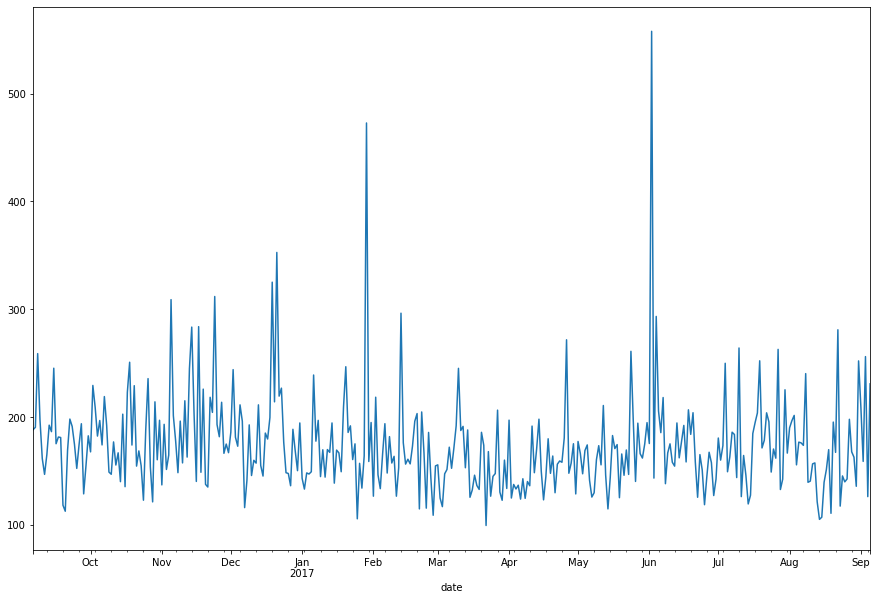

In [26]:
price_timeline = df_price_query.groupby(['date'])['price'].mean()
plt.figure(figsize=(15,10))
price_timeline.plot(kind='line')

<b>The chart above shows spike at the end of January and at the Beginnning of June. This shows that time of year does have an effect in Boston Airbnb pricing.</b>

In [27]:
df_price_query['month'] = pd.DatetimeIndex(df_price_query['date']).month
df_price_query['day'] = pd.DatetimeIndex(df_price_query['date']).day
df_price_query['year'] = pd.DatetimeIndex(df_price_query['date']).year
df_price_query

,date,available,listing_id,price,month,day,year
0,2017-09-05,f,12147973,250.0,9,5,2017
1,2017-09-04,f,12147973,65.0,9,4,2017
2,2017-09-03,f,12147973,65.0,9,3,2017
3,2017-09-02,f,12147973,75.0,9,2,2017
4,2017-09-01,f,12147973,79.0,9,1,2017
...,...,...,...,...,...,...,...
3580,2016-11-14,t,849408,69.0,11,14,2016
3581,2016-11-13,t,849408,150.0,11,13,2016
3582,2016-11-12,t,849408,198.0,11,12,2016
3583,2016-11-11,t,849408,65.0,11,11,2016


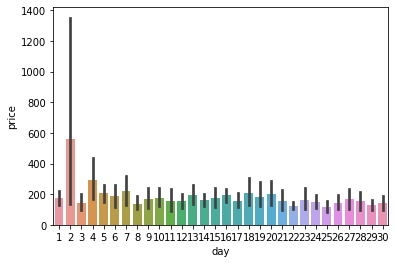

In [64]:
june = df_price_query[df_price_query['month'] == 6]
sns.barplot(data=june, x='day',y='price')

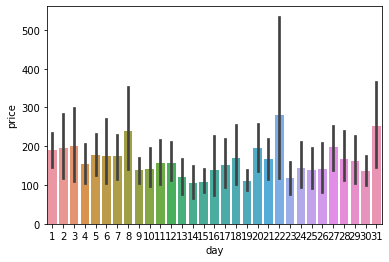

In [65]:
aug = df_price_query[df_price_query['month'] == 8]
sns.barplot(data=aug, x='day',y='price')

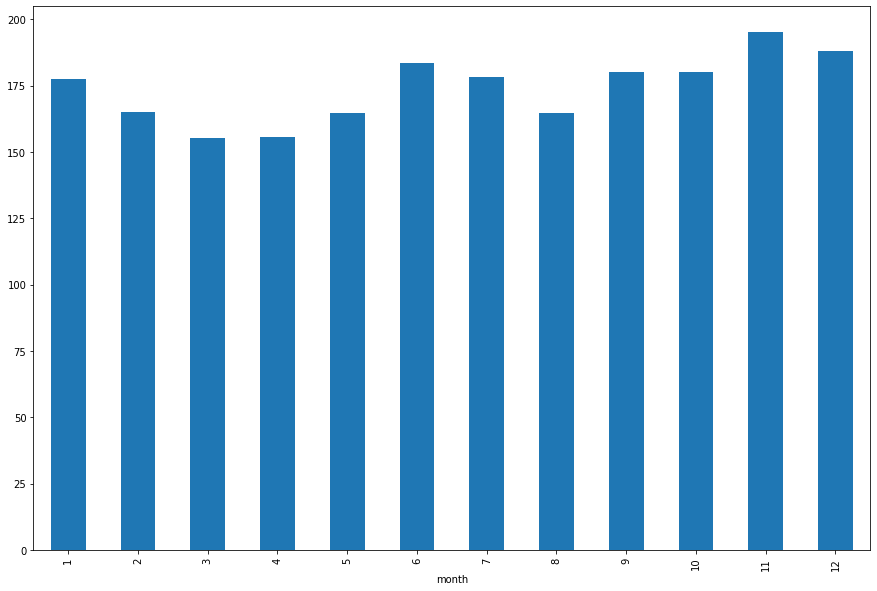

In [28]:
price_month = df_price_query.groupby(['month'])['price'].mean()
plt.figure(figsize=(15,10))
price_month.plot(kind='bar')

<b> looks like November and December have the highest average price listings </b>

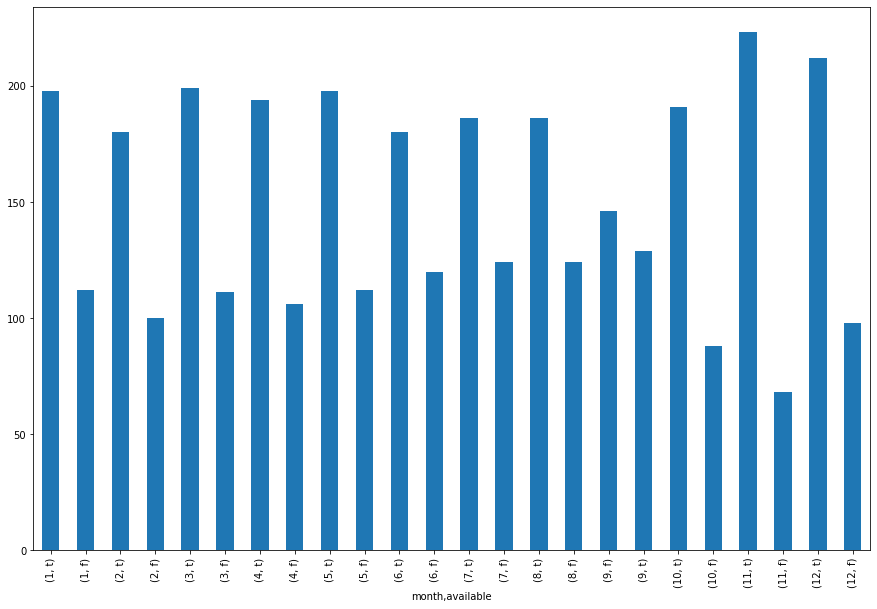

In [29]:
month_availability = df_price_query.groupby(['month'])['available'].value_counts()
plt.figure(figsize=(15,10))
month_availability.plot(kind='bar')


<b>I am going to base my anaysis on the assumtion that availaibity "f" mean that the unit is booked and "t" means that the unit is available to be books. So based on that, it looks like most bookings are done in August, were the prices to book are near the lowest for the year.</b>

In [30]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [31]:
listings.loc[listings['id'] == 6976].weekly_price

2    $395.00
Name: weekly_price, dtype: object

In [32]:
listings.property_type.value_counts()

Apartment          2612
House               562
Condominium         231
Townhouse            54
Bed & Breakfast      41
Loft                 39
Other                17
Boat                 12
Villa                 6
Entire Floor          4
Dorm                  2
Guesthouse            1
Camper/RV             1
Name: property_type, dtype: int64

                      price
property_type              
Guesthouse       289.000000
Boat             268.833333
Other            229.941176
Condominium      190.246753
Villa            189.500000
Loft             185.410256
Apartment        181.966692
Townhouse        149.037037
House            131.599644
Bed & Breakfast  129.365854
Entire Floor     122.000000
Dorm              62.500000
Camper/RV         60.000000


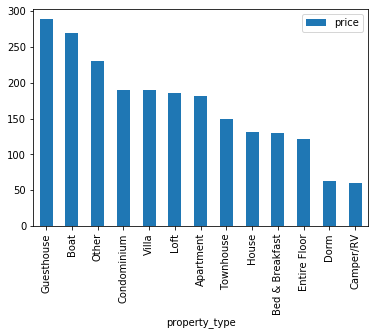

In [33]:
# lets see how value types influence price
property_type_price = listings.groupby(['property_type'])['price'].mean().reset_index().sort_values(by='price', ascending=False)
property_type_price = property_type_price.set_index('property_type')
print(property_type_price)
property_type_price.plot(kind='bar')

                 availability_30
property_type                   
Boat                   22.750000
Other                  12.705882
Guesthouse             12.000000
House                   9.516014
Entire Floor            9.500000
Bed & Breakfast         8.829268
Apartment               8.584609
Townhouse               8.314815
Condominium             6.926407
Loft                    6.307692
Dorm                    5.500000
Camper/RV               4.000000
Villa                   1.500000


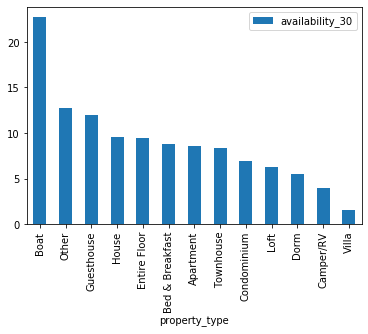

In [34]:
property_type_availability = listings.groupby(['property_type'])['availability_30'].mean().reset_index().sort_values(by='availability_30', ascending=False)
property_type_availability = property_type_availability.set_index('property_type')
print(property_type_availability)
property_type_availability.plot(kind='bar')

In [35]:
# how well do these property types sell? 37% of are booked up for 30 days 
listings.availability_30.value_counts()/listings.shape[0]

0     0.376290
29    0.054951
30    0.052720
2     0.041283
5     0.038215
3     0.035146
4     0.034031
1     0.033752
6     0.029847
7     0.025941
11    0.023152
8     0.020642
10    0.019247
9     0.018689
12    0.016457
15    0.014784
13    0.014784
14    0.014784
17    0.014226
26    0.012273
18    0.012273
20    0.011994
28    0.011158
24    0.011158
27    0.009763
21    0.009484
23    0.009205
19    0.008926
16    0.008647
25    0.008647
22    0.007531
Name: availability_30, dtype: float64

In [36]:
listings.availability_60.value_counts()/listings.shape[0]

0     0.309066
59    0.053556
60    0.047699
4     0.021478
5     0.016736
        ...   
30    0.006974
41    0.006695
46    0.005579
52    0.005300
49    0.005300
Name: availability_60, Length: 61, dtype: float64

In [37]:
listings.availability_90.value_counts()/listings.shape[0]

0     0.261646
89    0.052162
90    0.043794
65    0.014505
34    0.013389
        ...   
20    0.003905
24    0.003905
26    0.003905
11    0.003626
76    0.003626
Name: availability_90, Length: 91, dtype: float64

In [38]:
listings.availability_365.value_counts()/listings.shape[0]

0      0.189400
365    0.028731
364    0.026499
179    0.018410
248    0.015342
         ...   
118    0.000279
230    0.000279
100    0.000279
189    0.000279
265    0.000279
Name: availability_365, Length: 348, dtype: float64

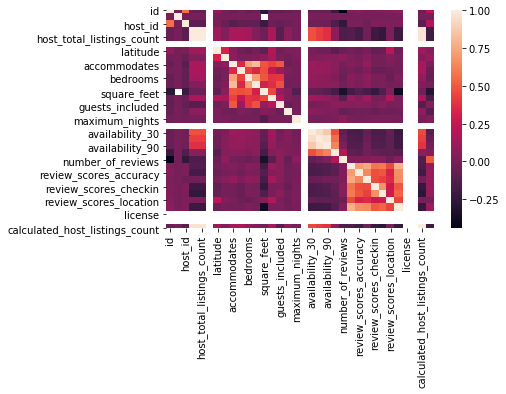

In [39]:
sns.heatmap(listings.corr())

In [40]:
quant_cols = listings.select_dtypes(include=['int','float'])
quant_cols.columns

Index(['id', 'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'bathrooms', 'bedrooms', 'beds', 'square_feet', 'price',
       'has_availability', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'jurisdiction_names',
       'reviews_per_month'],
      dtype='object')

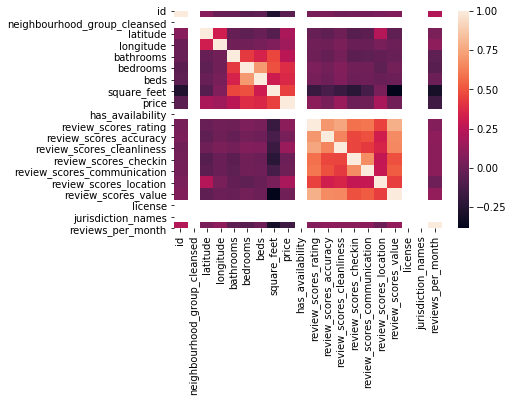

In [41]:
sns.heatmap(quant_cols.corr())

In [96]:
# looks like bed, square_feet, bedrooms, bathrooms, reviews_scores_locations, reviews_score_cleanliness have strong
# correlation to price. With this said I want to take a look at these values more specifically and check their values
features = ['price','beds','square_feet','bedrooms','bathrooms','review_scores_location','review_scores_cleanliness']
X_quant = listings[features] 

print(X_quant.shape)
print(X_quant.isnull().sum())
print(X_quant.dtypes)

(3585, 7)
price                           0
beds                            9
square_feet                  3529
bedrooms                       10
bathrooms                      14
review_scores_location        822
review_scores_cleanliness     818
dtype: int64
price                        float64
beds                         float64
square_feet                  float64
bedrooms                     float64
bathrooms                    float64
review_scores_location       float64
review_scores_cleanliness    float64
dtype: object


In [109]:
#cols = [col for col in X_quant.columns if X_quant[col].any()]
#X_quant[cols] = X_quant[cols].astype(int)

In [112]:
# Feature Engineering - Editing Nan Values out
#X_quant[X_quant.beds.isnull()]
print(X_quant[X_quant.beds == 1].bedrooms.value_counts())

print(X_quant[X_quant['bathrooms'].isnull()])

# 1. For the most part if there is 1 room available, there is also only 1 bed
# and if there is two rooms available, there are 2 beds.
# Going to replace all bed nan values to match the room amount

X_quant['beds'] = X_quant["beds"].mask(pd.isnull, X_quant['bedrooms'])


# 2. For Nan Bedrooms, I will replace them with the same value of beds. If 1 bed, then 1 room.

X_quant['bedrooms'] = X_quant["bedrooms"].mask(pd.isnull, X_quant['beds'])



1.0    1925
0.0     230
2.0      18
4.0       1
Name: bedrooms, dtype: int64
      price  beds  square_feet  bedrooms  bathrooms  review_scores_location  \
103    85.0   1.0          NaN       1.0        NaN                    10.0   
630    35.0   1.0          NaN       1.0        NaN                     NaN   
755    99.0   1.0          NaN       1.0        NaN                    10.0   
800   167.0   1.0          NaN       1.0        NaN                     9.0   
820    60.0   1.0          NaN       1.0        NaN                     5.0   
825    60.0   1.0          NaN       1.0        NaN                     5.0   
888   163.0   1.0          NaN       1.0        NaN                     9.0   
910    53.0   1.0          NaN       1.0        NaN                     NaN   
989    98.0   1.0          NaN       1.0        NaN                    10.0   
1120  135.0   1.0          NaN       1.0        NaN                    10.0   
2196  249.0   1.0          NaN       1.0        NaN   

C:\Users\ethanwilliams\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\ethanwilliams\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [85]:
X_quant[X_quant.beds.isnull()]

,price,beds,square_feet,bedrooms,bathrooms,review_scores_location,review_scores_cleanliness,bedss
494,99.0,NaN,NaN,1.0,1.0,10.0,10.0,<function <lambda> at 0x0000004DDC3C63A8>
755,99.0,NaN,NaN,1.0,NaN,10.0,9.0,<function <lambda> at 0x0000004DDC3C63A8>
820,60.0,NaN,NaN,1.0,NaN,5.0,5.0,<function <lambda> at 0x0000004DDC3C63A8>
825,60.0,NaN,NaN,1.0,NaN,5.0,5.0,<function <lambda> at 0x0000004DDC3C63A8>
910,53.0,NaN,NaN,1.0,NaN,NaN,NaN,<function <lambda> at 0x0000004DDC3C63A8>
2203,80.0,NaN,NaN,1.0,1.0,NaN,NaN,<function <lambda> at 0x0000004DDC3C63A8>
2819,57.0,NaN,NaN,1.0,NaN,9.0,9.0,<function <lambda> at 0x0000004DDC3C63A8>
2865,60.0,NaN,NaN,1.0,1.0,9.0,9.0,<function <lambda> at 0x0000004DDC3C63A8>
3557,60.0,NaN,NaN,1.0,1.0,NaN,NaN,<function <lambda> at 0x0000004DDC3C63A8>


In [43]:
# for property square feet I imagine that the neighbourhood they are in would have an say on their average.
X_quant.groupby(['square_feet'])['price'].mean().reset_index().sort_values(by='price', ascending=False)

,square_feet,price
33,2000.0,612.500000
35,2300.0,525.000000
1,2.0,400.000000
20,850.0,384.500000
26,1050.0,359.000000
22,900.0,342.000000
34,2200.0,300.000000
23,920.0,295.000000
27,1100.0,285.000000
15,650.0,279.000000


In [44]:
listings.groupby(['square_feet'])['availability_365'].mean().reset_index().sort_values(by='availability_365',ascending=False)

,square_feet,availability_365
26,1050.0,360.000000
15,650.0,359.000000
5,190.0,358.000000
20,850.0,357.000000
27,1100.0,348.000000
22,900.0,347.000000
2,12.0,347.000000
7,225.0,344.000000
6,200.0,340.500000
33,2000.0,338.500000


In [45]:
qual_cols = listings.select_dtypes(include=['object'])
qual_cols.columns

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed', 'city', 'state',
       'zipcode', 'market', 'smart_location', 'country_code', 'country',
       'is_location_exact', 'property_type', 'room_type', 'bed_type',
       'amenities', 'weekly_price', 'monthly_price', 'security_deposit',
       'cleaning_fee', 'extra_people', 'calendar_updated',
       'calendar_last_scraped', 'first_review', 'la

In [ ]:
# lets see what how well the quant vars only play on price prediction
